# It's Corn (PogChamps \#3) Kaggle Competition - Experiment 9
## Testing Oversampling

This notebook will be taking a look at oversampling for this competition.

## Setup Competition Files

In [1]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

In [2]:
comp = 'kaggle-pog-series-s01e03'

In [3]:
path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

In [4]:
import timm
from fastai.vision.all import *
set_seed(42)

# path.ls()

In [5]:
csv_path = path/'corn'

In [6]:
trn_path = csv_path/'train'
# trn_path.ls()

In [7]:
tst_path = csv_path/'test'
# tst_path.ls()

Grab csv lists

In [8]:
csv_path = path/'corn'
train_csv_fname = csv_path/'train.csv'
trn_files = pd.read_csv(train_csv_fname)
test_csv_fname = csv_path/'test.csv'
tst_files = pd.read_csv(test_csv_fname)
ss_csv_fname = csv_path/'sample_submission.csv'
ss = pd.read_csv(ss_csv_fname)

# Take a look at the class distribution in the test set
Let's take a look again at the test set.

In [9]:
trn_files['label'].value_counts()

pure          5837
broken        4554
discolored    2504
silkcut       1427
Name: label, dtype: int64

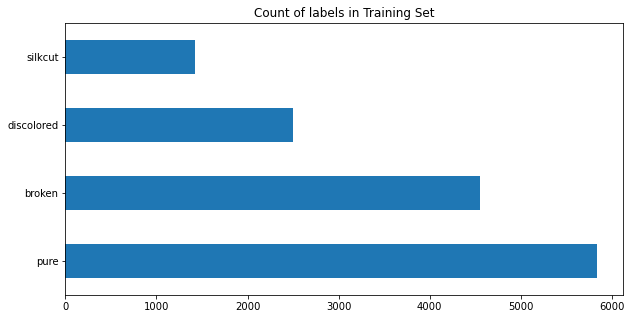

In [10]:
trn_files['label'].value_counts() \
    .plot(kind='barh',
          figsize=(10,5),
          title='Count of labels in Training Set')
plt.show()

There's a considerable class imbalance in the training set!  That's where oversampling can be a tool to try to combat this problem.  In previous experiments we noticed that a lot of the errors in the confusion matrix were predicting the classes that are most represented instead of the actual class.  Let's see if we can regenerate this!

## Analyzing errors on small model train

In [11]:
def train_accum_es(arch, batch=aug_transforms(size=256), item=Resize(256, method=ResizeMethod.Pad, pad_mode=PadMode.Border), accum=1, finetune=True, epochs=12, new_seed=42, early_stop=True, monitor='accuracy', min_delta=0.01, patience=3):
    dls = ImageDataLoaders.from_df(trn_files, seed=new_seed,
        path=csv_path, fn_col=2, label_col=3,
        valid_pct=0.2, item_tfms=item,
        batch_tfms=batch,
        bs=64//accum)
    cbs = GradientAccumulation(64) if accum else []
    learn = vision_learner(dls, arch, metrics=accuracy, cbs=cbs).to_fp16()
    _valley, _slide = learn.lr_find(suggest_funcs=(valley,slide))
    train_cbs = [EarlyStoppingCallback(monitor=monitor, min_delta=min_delta, patience=patience),SaveModelCallback(monitor=monitor, min_delta=min_delta)] if early_stop else []
    if finetune:
        learn.fine_tune(epochs, _slide, cbs=train_cbs)
    else:
        learn.unfreeze()
        learn.fit_one_cycle(epochs, _slide, cbs=train_cbs)
    return learn#, learn.tta(dl=dls.test_dl(tst_files)) #Remove TTA for these tests

epoch,train_loss,valid_loss,accuracy,time
0,0.969606,0.849094,0.691341,01:10


Better model found at epoch 0 with accuracy value: 0.6913408041000366.


epoch,train_loss,valid_loss,accuracy,time
0,0.624712,0.626185,0.751397,01:37
1,0.560453,0.622956,0.756634,01:37
2,0.511740,0.617172,0.759427,01:37
3,0.480313,0.664204,0.764316,01:37
4,0.418019,0.632246,0.761522,01:37
5,0.348987,0.678090,0.769553,01:37
6,0.279609,0.849731,0.761173,01:37


Better model found at epoch 0 with accuracy value: 0.751396656036377.
Better model found at epoch 3 with accuracy value: 0.764315664768219.
No improvement since epoch 3: early stopping


[0.6642040610313416, 0.764315664768219]


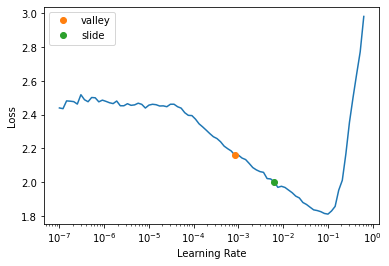

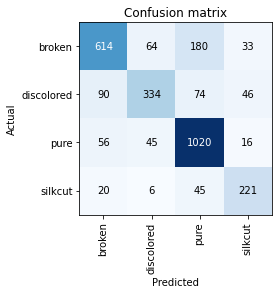

In [12]:
arch = 'convnext_large_in22k'

learn=train_accum_es(arch, epochs=20, early_stop=True)
print(learn.validate())

# Plot confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [13]:
interp.most_confused()

[('broken', 'pure', 180),
 ('discolored', 'broken', 90),
 ('discolored', 'pure', 74),
 ('broken', 'discolored', 64),
 ('pure', 'broken', 56),
 ('discolored', 'silkcut', 46),
 ('pure', 'discolored', 45),
 ('silkcut', 'pure', 45),
 ('broken', 'silkcut', 33),
 ('silkcut', 'broken', 20),
 ('pure', 'silkcut', 16),
 ('silkcut', 'discolored', 6)]

Distribution of labels in train set:

In [14]:
trn_files['label'].value_counts()/trn_files['label'].value_counts().sum()

pure          0.407555
broken        0.317972
discolored    0.174836
silkcut       0.099637
Name: label, dtype: float64

Wrong predictions by predicted class:
1. pure: 299 (299/675 = 44%)
1. broken: 166 (25%)
1. discolored: 115 (17%)
1. silkcut: 95 (14%)

As you can see, the wrong predictions and the class imbalance are verys imilar distributions and keep the absolute ordering.  As such, oversampling might help!

Clear GPU Memory

In [17]:
import gc

# Attempt to clear GPU memory (as best we can)
del(learn)
print(torch.cuda.list_gpu_processes())
gc.collect()
torch.cuda.empty_cache()

GPU:0
process       2454 uses    21077.000 MB GPU memory


## Testing out an manual oversampling method

An example of oversampling the MNIST dataset can be found [here](https://www.kaggle.com/code/tanlikesmath/oversampling-mnist-with-fastai/notebook) where an artificially unbalanced dataset is created and oversampling allows for similar performance as the entire (mostly balanced) dataset gave under similar training.  We will try to wrap some of their techniques up into a coherent train method but in this section we try to understand the buidling blocks of an oversample method.

Create train and validation datasets:

In [11]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(trn_files,test_size=0.2) # Here we will perform an 80%/20% split of the dataset, with stratification to keep similar distribution in validation set

Current distributions:

<AxesSubplot:>

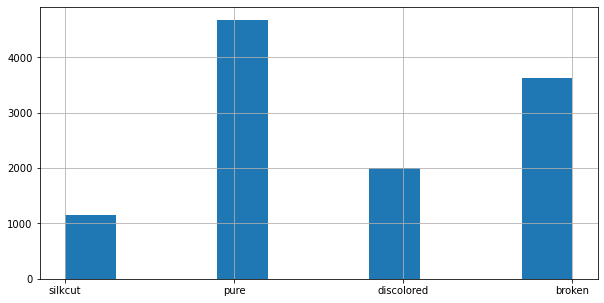

In [12]:
train_df['label'].hist(figsize = (10, 5))

In [13]:
train_df['label'].value_counts()

pure          4678
broken        3633
discolored    1997
silkcut       1149
Name: label, dtype: int64

<AxesSubplot:>

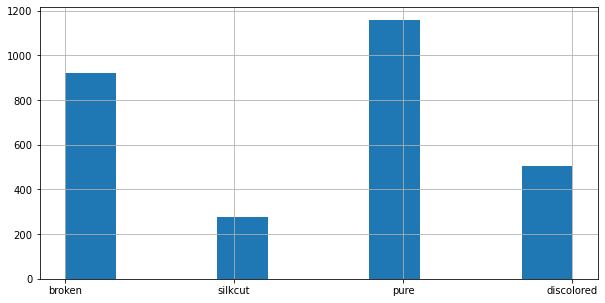

In [14]:
val_df['label'].hist(figsize = (10, 5))

In [15]:
val_df['label'].value_counts()

pure          1159
broken         921
discolored     507
silkcut        278
Name: label, dtype: int64

The number of labels can be computed as follows:

In [16]:
num_labels = train_df['label'].nunique()
num_labels

4

Let's compute a sample proportions table:

In [17]:
# proportions = pd.DataFrame({0: [0.5],
#                             1: [0.05],
#                             2: [0.1],
#                             3: [0.03],
#                             4: [0.03],
#                             5: [0.03],
#                             6: [0.03],
#                             7: [0.5],
#                             8: [0.5],
#                             9: [0.5],
#                            })
# proportions

In [18]:
proportions = trn_files['label'].value_counts().max()/trn_files['label'].value_counts()
# proportions = proportions/proportions.max()
proportions.to_frame()

,label
pure,1.000000
broken,1.281730
discolored,2.331070
silkcut,4.090399


Oversampling can be done as follows:

In [19]:
balanced_train_df = train_df.groupby('label').apply(lambda x: x.sample(replace=True, frac=proportions[x.name]))

Let's look at the oversampled distribution!

<AxesSubplot:>

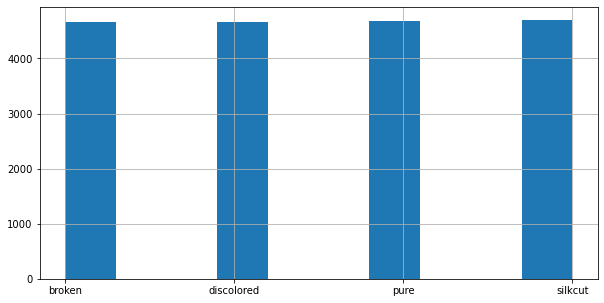

In [20]:
balanced_train_df['label'].hist(figsize = (10, 5))

That looks balanced!  We chose to keep the same number of images in our biggest class as we had before sampling (not guaranteed to have all of them I don't think as we had to set `resample=True`).  The smaller classes were then "oversampled" so the dataset should be larger.

Old size:

In [21]:
train_df['label'].count()

11457

New size:

In [22]:
balanced_train_df['label'].count()

18690

Let's see how many of the original images survived the sampling:

In [23]:
balanced_train_df.nunique()

seed_id    8507
view          2
image      8507
label         4
dtype: int64

Only ~8500 out of the 11457 remain (not ideal).  Could do a uniform sample of this dataframe but might be able to do better.

## Generating a reusable class for oversampling

Resources:

- [oversample example](https://gist.github.com/scart97/8c33b84db8d6375739b57afab1355900)
- [datablock tutorial](https://docs.fast.ai/tutorial.datablock.html)

In [24]:
def oversample(frame: pd.DataFrame):
    max_size = frame['label'].value_counts().max()
    lst = [frame]
    for class_index, group in frame.groupby('label'):
        lst.append(group.sample(max_size-len(group), replace=True))
    return pd.concat(lst)

After oversampling you can check that the number of items for each class is very similar or equal

In [25]:
oversampled_train_df = oversample(train_df) # <------- TRAINING DATAFRAME ONLY
oversampled_train_df['label'].value_counts()

silkcut       4678
pure          4678
discolored    4678
broken        4678
Name: label, dtype: int64

Create a dataframe to sample from

In [26]:
def create_dataset(train_data, valid_data):
    """
        Helper function to extract the dataframe from the DataLoaders
    """
    
    train_rows = train_data
    is_valid = [False] * len(train_rows)
    train_rows['is_valid'] = is_valid
    
    valid_rows = valid_data
    is_valid = [True] * len(valid_rows)
    valid_rows['is_valid'] = is_valid
    
    return pd.concat([train_rows, valid_rows])

To train, we now concat the oversampled training dataframe with the validation one

In [27]:
oversampled_df = pd.concat((oversampled_train_df, val_df))
oversampled_df.head()

,seed_id,view,image,label
3804,4665,bottom,train/04665.png,silkcut
6557,8112,top,train/08112.png,pure
3485,4269,bottom,train/04269.png,pure
4333,5340,top,train/05340.png,discolored
13239,16451,bottom,train/16451.png,broken


In [28]:
dataset_df = create_dataset(oversampled_df, val_df)
dataset_df

,seed_id,view,image,label,is_valid
3804,4665,bottom,train/04665.png,silkcut,False
6557,8112,top,train/08112.png,pure,False
3485,4269,bottom,train/04269.png,pure,False
4333,5340,top,train/05340.png,discolored,False
13239,16451,bottom,train/16451.png,broken,False
...,...,...,...,...,...
6107,7547,bottom,train/07547.png,pure,True
12606,15661,top,train/15661.png,pure,True
408,489,bottom,train/00489.png,broken,True
6908,8534,top,train/08534.png,pure,True


In [29]:
_data_block_path = csv_path
_item = Resize(256)
_batch = aug_transforms(size=256)
_x_col = 2
_y_col = 3

data_block = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   splitter=ColSplitter(), #splits on is_valid
                   get_x=ColReader(_x_col, pref=_data_block_path),
                   get_y=ColReader(_y_col),
                   item_tfms=_item,
                   batch_tfms=_batch)

In [30]:
data = data_block.dataloaders(dataset_df)

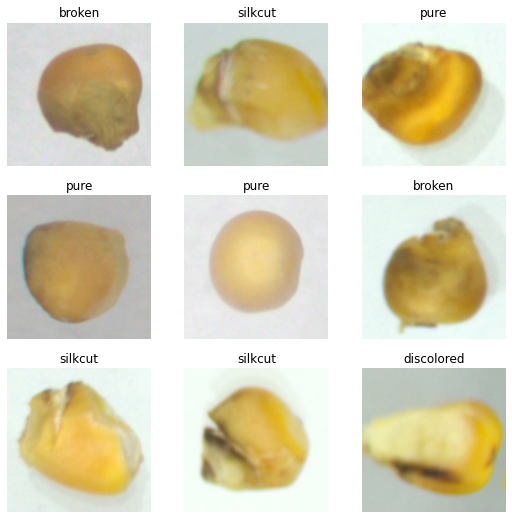

In [31]:
data.show_batch()

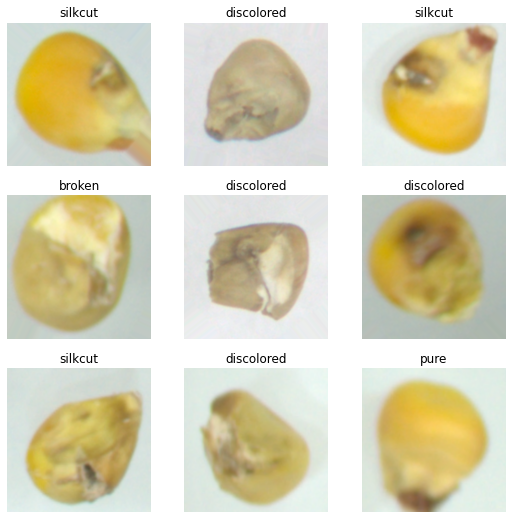

In [32]:
from sklearn.model_selection import train_test_split
import pickle

class OversampleDataloaderGenerator:
    def oversample(self):
        max_size = self.train_df['label'].value_counts().max()
        lst = [self.train_df]
        for class_index, group in self.train_df.groupby('label'):
            lst.append(group.sample(max_size-len(group), replace=True))
        self.oversampled_train_df = pd.concat(lst)

    def create_dataset(self):
        """
            Helper function to create the dataframe from the original data
        """

        train_rows = self.train_df
        is_valid = [False] * len(train_rows)
        train_rows['is_valid'] = is_valid

        valid_rows = self.val_df
        is_valid = [True] * len(valid_rows)
        valid_rows['is_valid'] = is_valid

        self.dataset_df = pd.concat([train_rows, valid_rows])
    
    def create_oversampled_dataset(self):
        """
            Helper function to create the dataframe from the original data
        """

        train_rows = self.oversampled_train_df
        is_valid = [False] * len(train_rows)
        train_rows['is_valid'] = is_valid

        valid_rows = self.val_df
        is_valid = [True] * len(valid_rows)
        valid_rows['is_valid'] = is_valid

        self.oversampled_dataset_df = pd.concat([train_rows, valid_rows])
    
    def create_oversampled_dataloader(self):
        """
            Helper function to create the oversampled DataLoader
        """

        self.data_block = DataBlock(blocks=(ImageBlock, CategoryBlock),
            splitter=ColSplitter(), #splits on is_valid
            get_x=ColReader(self.fn_col, pref=self.path),
            get_y=ColReader(self.label_col),
            item_tfms=self.item_tfms,
            batch_tfms=self.batch_tfms)
        
        self.oversampled_dl = self.data_block.dataloaders(self.oversampled_dataset_df, bs=self.bs, seed=self.seed)
    
    def export(self, filename='oversampled_dl_creator_export.pkl'):
        export_dict = {
            'train_df': self.train_df, 
            'oversampled_train_df': self.oversampled_train_df,
            'val_df': self.val_df, 
            'oversampled_dataset_df': self.oversampled_dataset_df, 
            }
        with open(filename, 'wb') as file:
            pickle.dump(export_dict, file)
    
    def __init__(self, train_files: pd.DataFrame, valid_pct=0.2, path='', item_tfms=Resize(256), batch_tfms=aug_transforms(size=256), fn_col=2, label_col=3, bs=64, seed=42):
        self.train_files = train_files
        self.valid_pct = valid_pct
        self.path = path
        self.item_tfms = item_tfms
        self.batch_tfms = batch_tfms
        self.fn_col = fn_col
        self.label_col = label_col
        self.bs = bs
        self.seed = seed
        
        # Split train_files into train and validation DataFrames
        self.train_df, self.val_df = train_test_split(self.train_files,test_size=valid_pct) # Here we will perform an 80%/20% split of the dataset by default, with stratification to keep similar distribution in validation set
#         create_dataset()
        self.oversample()
        self.create_oversampled_dataset()
        self.create_oversampled_dataloader()

        

# Test class
_batch = aug_transforms(size=(256,256),
            min_scale=1.0, min_zoom=1.0, max_zoom=1.2,
            max_lighting=0.0, p_lighting=0.0,
            max_warp=0.0, p_affine=0.75,
            max_rotate=90.0,
            do_flip=True, flip_vert=True, pad_mode='border')
        
oversampled_dl_gen = OversampleDataloaderGenerator(
    train_df, valid_pct=0.2,
    path=csv_path, item_tfms=Resize(256),
    batch_tfms=_batch,
    fn_col=2, label_col=3)

oversampled_dl_gen.oversampled_dl.show_batch()
oversampled_dl_gen.export()

In [33]:
# Test load dataset export
with open('oversampled_dl_creator_export.pkl', 'rb') as file:
    export_dict = pickle.load(file)

export_dict['train_df']

,seed_id,view,image,label
1344,1622,top,train/01622.png,pure
6343,7839,bottom,train/07839.png,silkcut
10796,13419,bottom,train/13419.png,broken
6752,8348,top,train/08348.png,pure
7610,9398,top,train/09398.png,pure
...,...,...,...,...
1467,1767,top,train/01767.png,broken
10506,13043,bottom,train/13043.png,pure
1853,2255,bottom,train/02255.png,broken
628,750,bottom,train/00750.png,silkcut


In [34]:
export_dict['oversampled_train_df']

,seed_id,view,image,label,is_valid
1344,1622,top,train/01622.png,pure,False
6343,7839,bottom,train/07839.png,silkcut,False
10796,13419,bottom,train/13419.png,broken,False
6752,8348,top,train/08348.png,pure,False
7610,9398,top,train/09398.png,pure,False
...,...,...,...,...,...
1110,1342,top,train/01342.png,silkcut,False
6882,8507,bottom,train/08507.png,silkcut,False
12163,15114,bottom,train/15114.png,silkcut,False
8362,10354,top,train/10354.png,silkcut,False


In [35]:
export_dict['oversampled_train_df'].nunique()

seed_id     9165
view           2
image       9165
label          4
is_valid       1
dtype: int64

In [36]:
export_dict['val_df']

,seed_id,view,image,label,is_valid
22,26,bottom,train/00026.png,broken,True
4587,5651,top,train/05651.png,broken,True
13830,17186,top,train/17186.png,pure,True
10163,12603,top,train/12603.png,broken,True
6371,7874,top,train/07874.png,pure,True
...,...,...,...,...,...
12846,15963,top,train/15963.png,pure,True
7965,9841,top,train/09841.png,pure,True
8920,11053,top,train/11053.png,pure,True
14037,17434,bottom,train/17434.png,pure,True


In [37]:
export_dict['oversampled_dataset_df']

,seed_id,view,image,label,is_valid
1344,1622,top,train/01622.png,pure,False
6343,7839,bottom,train/07839.png,silkcut,False
10796,13419,bottom,train/13419.png,broken,False
6752,8348,top,train/08348.png,pure,False
7610,9398,top,train/09398.png,pure,False
...,...,...,...,...,...
12846,15963,top,train/15963.png,pure,True
7965,9841,top,train/09841.png,pure,True
8920,11053,top,train/11053.png,pure,True
14037,17434,bottom,train/17434.png,pure,True


# Try training with oversampling and early stopping

In [38]:
def train_accum_es_over(arch, batch=aug_transforms(size=256), item=Resize(256, method=ResizeMethod.Pad, pad_mode=PadMode.Border), accum=1, finetune=True, epochs=12, new_seed=42, early_stop=True, monitor='accuracy', min_delta=0.01, patience=3):
    oversampled_dl_gen = OversampleDataloaderGenerator(
        trn_files, seed=new_seed,
        path=csv_path, fn_col=2, label_col=3,
        valid_pct=0.2, item_tfms=item,
        batch_tfms=batch,
        bs=64//accum)
    dls = oversampled_dl_gen.oversampled_dl
    cbs = GradientAccumulation(64) if accum else []
    learn = vision_learner(dls, arch, metrics=accuracy, cbs=cbs).to_fp16()
    _valley, _slide = learn.lr_find(suggest_funcs=(valley,slide))
    train_cbs = [EarlyStoppingCallback(monitor=monitor, min_delta=min_delta, patience=patience),SaveModelCallback(monitor=monitor, min_delta=min_delta)] if early_stop else []
    if finetune:
        learn.fine_tune(epochs, _slide, cbs=train_cbs)
    else:
        learn.unfreeze()
        learn.fit_one_cycle(epochs, _slide, cbs=train_cbs)
    return learn#, learn.tta(dl=dls.test_dl(tst_files)) #Remove TTA for these tests

epoch,train_loss,valid_loss,accuracy,time
0,0.888833,0.911394,0.682373,02:00


Better model found at epoch 0 with accuracy value: 0.6823734641075134.


epoch,train_loss,valid_loss,accuracy,time
0,0.643797,0.639226,0.750785,02:48
1,0.578884,0.609702,0.765445,02:48
2,0.521867,0.582335,0.768935,02:48
3,0.477709,0.564059,0.779756,02:48
4,0.407594,0.569798,0.782199,02:48
5,0.380663,0.575682,0.784991,02:48
6,0.328844,0.588486,0.782548,02:48
7,0.291739,0.619132,0.782897,02:48
8,0.266064,0.638998,0.786387,02:48
9,0.238752,0.671530,0.779407,02:48


Better model found at epoch 0 with accuracy value: 0.7507853507995605.
Better model found at epoch 1 with accuracy value: 0.7654450535774231.
Better model found at epoch 2 with accuracy value: 0.7689354419708252.
Better model found at epoch 3 with accuracy value: 0.7797556519508362.
Better model found at epoch 4 with accuracy value: 0.782198965549469.
Better model found at epoch 5 with accuracy value: 0.7849912643432617.
Better model found at epoch 8 with accuracy value: 0.7863874435424805.
No improvement since epoch 8: early stopping


[0.63899827003479, 0.7863874435424805]


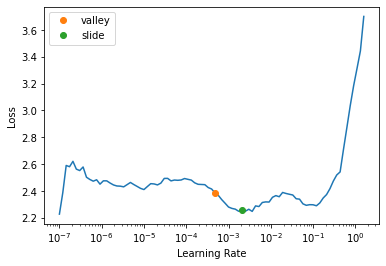

In [41]:
arch = 'convnext_large_in22k'
learn=train_accum_es_over(arch, accum=2, epochs=40, patience=5, min_delta=0.001, early_stop=True)
print(learn.validate())

Generate confusion matrix

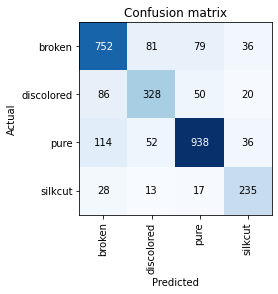

In [42]:
# Plot confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [43]:
interp.most_confused()

[('pure', 'broken', 114),
 ('discolored', 'broken', 86),
 ('broken', 'discolored', 81),
 ('broken', 'pure', 79),
 ('pure', 'discolored', 52),
 ('discolored', 'pure', 50),
 ('broken', 'silkcut', 36),
 ('pure', 'silkcut', 36),
 ('silkcut', 'broken', 28),
 ('discolored', 'silkcut', 20),
 ('silkcut', 'pure', 17),
 ('silkcut', 'discolored', 13)]

Clear GPU Memory

In [44]:
import gc

# Attempt to clear GPU memory (as best we can)
del(learn)
print(torch.cuda.list_gpu_processes())
gc.collect()
torch.cuda.empty_cache()

GPU:0
process      30357 uses    14113.000 MB GPU memory


/home/speers/anaconda3/envs/fastai/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484809662/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


epoch,train_loss,valid_loss,accuracy,time
0,0.956096,0.741227,0.710646,02:13


Better model found at epoch 0 with accuracy value: 0.7106457352638245.


epoch,train_loss,valid_loss,accuracy,time
0,0.741202,0.631777,0.743805,02:51
1,0.643671,0.593508,0.756370,02:51
2,0.604226,0.581517,0.766492,02:51
3,0.527895,0.550308,0.782897,02:51
4,0.495954,0.546502,0.785689,02:51
5,0.475412,0.545116,0.787784,02:51
6,0.441578,0.544107,0.784293,02:51
7,0.399953,0.528972,0.788482,02:51
8,0.366779,0.554191,0.794415,02:51
9,0.374887,0.595915,0.782897,02:51


Better model found at epoch 0 with accuracy value: 0.7438045144081116.
Better model found at epoch 1 with accuracy value: 0.7563700079917908.
Better model found at epoch 2 with accuracy value: 0.7664921283721924.
Better model found at epoch 3 with accuracy value: 0.7828970551490784.
Better model found at epoch 4 with accuracy value: 0.7856893539428711.
Better model found at epoch 5 with accuracy value: 0.7877836227416992.
Better model found at epoch 8 with accuracy value: 0.7944153547286987.
No improvement since epoch 8: early stopping


[0.5541912913322449, 0.7944153547286987]


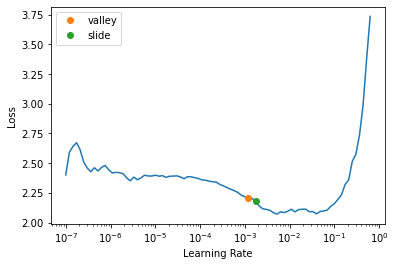

In [47]:
arch = 'swinv2_large_window12_192_22k'
batch = aug_transforms(size=(192,192),
        min_scale=1.0, min_zoom=1.0, max_zoom=1.2,
        max_lighting=0.1, p_lighting=0.75,
        max_warp=0.2, p_affine=0.75,
        max_rotate=90.0,
        do_flip=True, flip_vert=True, pad_mode='border')
item = Resize(256, method=ResizeMethod.Pad, pad_mode=PadMode.Border)
seed = 42

learn=train_accum_es_over(arch, batch=batch, item=item, new_seed=seed, accum=2, epochs=40, patience=5, min_delta=0.001, early_stop=True)
print(learn.validate())

Generate confusion matrix

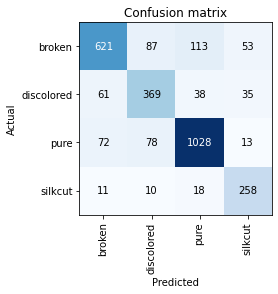

In [48]:
# Plot confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [49]:
interp.most_confused()

[('broken', 'pure', 113),
 ('broken', 'discolored', 87),
 ('pure', 'discolored', 78),
 ('pure', 'broken', 72),
 ('discolored', 'broken', 61),
 ('broken', 'silkcut', 53),
 ('discolored', 'pure', 38),
 ('discolored', 'silkcut', 35),
 ('silkcut', 'pure', 18),
 ('pure', 'silkcut', 13),
 ('silkcut', 'broken', 11),
 ('silkcut', 'discolored', 10)]

Clear GPU Memory

In [50]:
import gc

# Attempt to clear GPU memory (as best we can)
del(learn)
print(torch.cuda.list_gpu_processes())
gc.collect()
torch.cuda.empty_cache()

GPU:0
process      30357 uses    18319.000 MB GPU memory
